## Sales Forecasting
### A. Semoglou 

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import mstats

import xgboost as xg
import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline

***

### About Dataset

#### **Description**: [Kaggle WOMart dataset](https://www.kaggle.com/datasets/shelvigarg/sales-forecasting-womart-store/data)
#### Sales Forecasting WOMart Store
#### Forescast Sales with Exhaustive Retail Store Data
Your Client WOMart is a leading nutrition and supplement retail chain that offers a comprehensive range of products for all your wellness and fitness needs.

WOMart follows a multi-channel distribution strategy with 350+ retail stores spread across 100+ cities.

Effective forecasting for store sales gives essential insight into upcoming cash flow, meaning WOMart can more accurately plan the cashflow at the store level.

Sales data for 18 months from 365 stores of WOMart is available along with information on Store Type, Location Type for each store, Region Code for every store, Discount provided by the store on every day, Number of Orders everyday etc.

Your task is to predict the store sales for each store in the test set for the next two months.

#### **Train Data: TRAIN.csv** 
- `ID`: Unique Identifier for a row
- `Store_id`: Unique id for each Store
- `Store_Type`: Type of the Store
- `Location_Type`: Type of the location where Store is located
- `Region_Code`: Code of the Region where Store is located 
- `Date`: Information about the Date
- `Holiday`: If there is holiday on the given Date, 1 : Yes, 0 : No
- `Discount`: If discount is offered by store on the given Date, Yes/ No
- `Orders`: Number of Orders received by the Store on the given Day
- `Sales`: Total Sale for the Store on the given Day

#### **Test Data: TEST_FINAL.csv**
- `ID`: Unique Identifier for a row
- `Store_id`: Unique id for each Store
- `Store_Type`: Type of the Store
- `Location_Type`: Type of the location where Store is located
- `Region_Code`: Code of the Region where Store is located
- `Date`: Information about the Date
- `Holiday`: If there is holiday on the given Date, 1 : Yes, 0 : No
- `Discount`: If discount is offered by store on the given Date, Yes/ No

***

### Load Data

In [2]:
train_data = pd.read_csv('TRAIN.csv')
test_data = pd.read_csv('TEST_FINAL.csv')

In [3]:
test_data.shape

(22265, 8)

In [4]:
display(train_data.head(3))

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20


In [5]:
display(test_data.head(3))

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No


In [6]:
print(f'Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}')

Train data shape: (188340, 10)
Test data shape: (22265, 8)


In [7]:
display(train_data.info()), display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


None

(None, None)

In [8]:
display(train_data.isnull().sum()), display(test_data.isnull().sum())

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
dtype: int64

(None, None)

In [9]:
train_data.duplicated().sum(), test_data.duplicated().sum()

(0, 0)

***

### Preprocessing

In [10]:
# Replace zero sales values with a small positive value to minimize the impact of zero values on Errors
train_data['Sales'] = train_data['Sales'].apply(lambda x: x if x > 0 else 0.01)

# Apply winsorizstion for outlier handling
train_data['Sales'] = mstats.winsorize(train_data['Sales'], limits=[0.05, 0.05])

train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
train_data['Discount'] = train_data['Discount'].apply(lambda x: 1 if x == 'Yes' else 0)
test_data['Discount'] = test_data['Discount'].apply(lambda x: 1 if x == 'Yes' else 0)

In [11]:
# Continuity of days 

# Display the last date of the training data and the first date of the test data
last_train_date = train_data['Date'].iloc[-1]
first_test_date = test_data['Date'].iloc[0]

print(f"Last date in training data: {last_train_date}")
print(f"First date in test data: {first_test_date}")

# Check if the first test date is one day after the last train date
is_continuous = first_test_date == last_train_date + pd.Timedelta(days=1)
print(f"The first test date is one day after the last train date: {is_continuous}")

Last date in training data: 2019-05-31 00:00:00
First date in test data: 2019-06-01 00:00:00
The first test date is one day after the last train date: True


### Exploratory Data Analysis

- #### Average sales over time across all stores

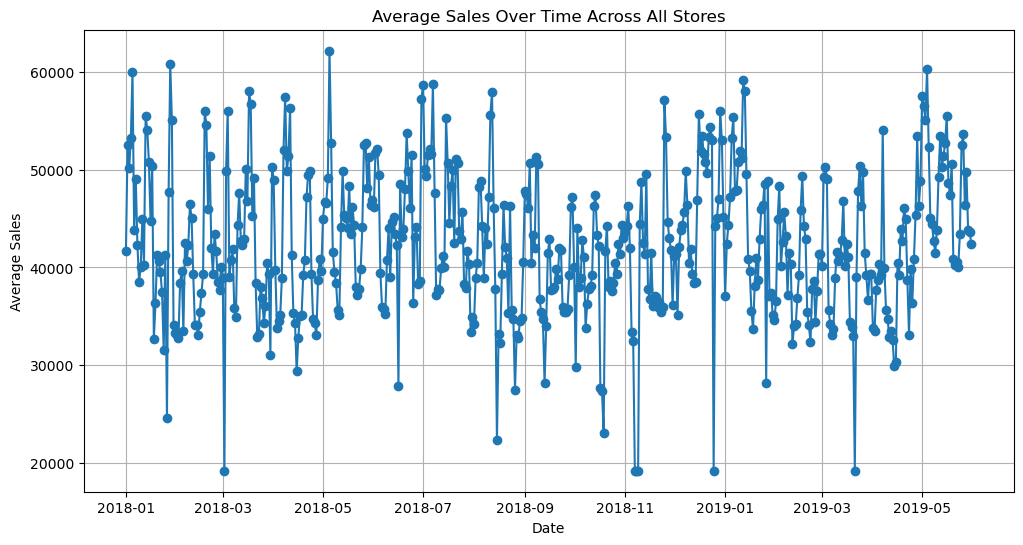

In [12]:
average_sales_data = train_data.groupby('Date')['Sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(average_sales_data['Date'], average_sales_data['Sales'], marker='o', linestyle='-')
plt.title('Average Sales Over Time Across All Stores')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

- #### Average sales by Store Type

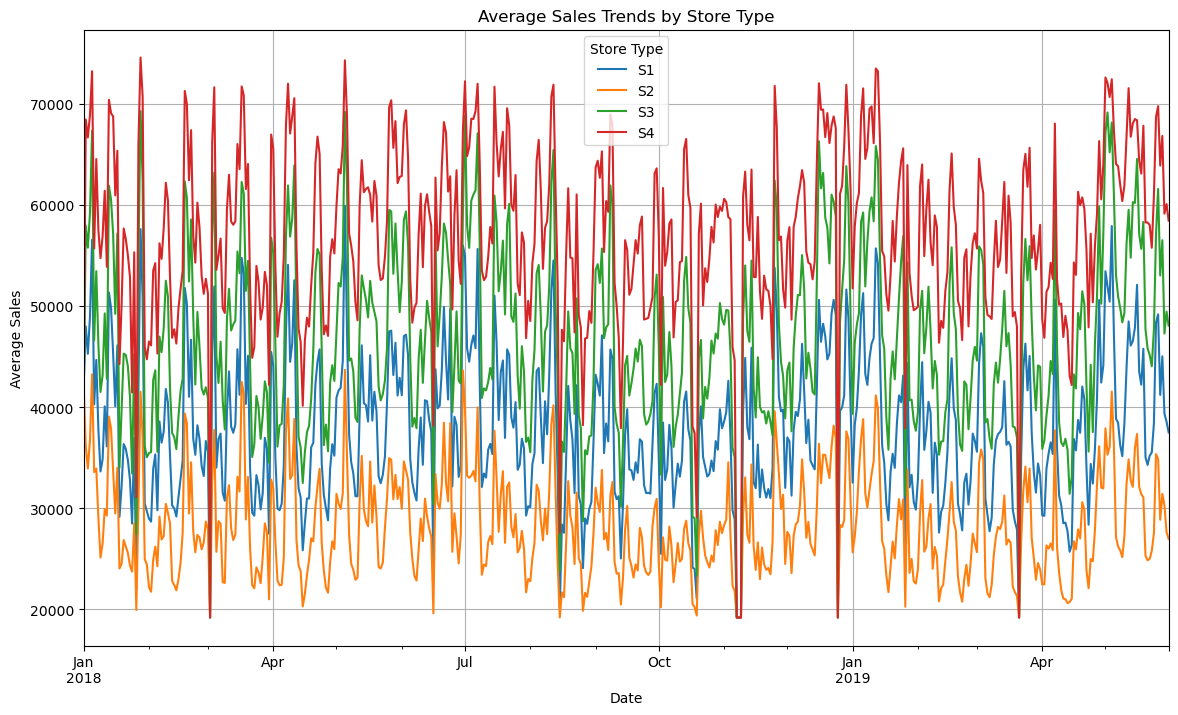

In [13]:
store_type_sales = train_data.groupby(['Date', 'Store_Type'])['Sales'].mean().unstack()

store_type_sales.plot(figsize=(14, 8))
plt.title('Average Sales Trends by Store Type')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

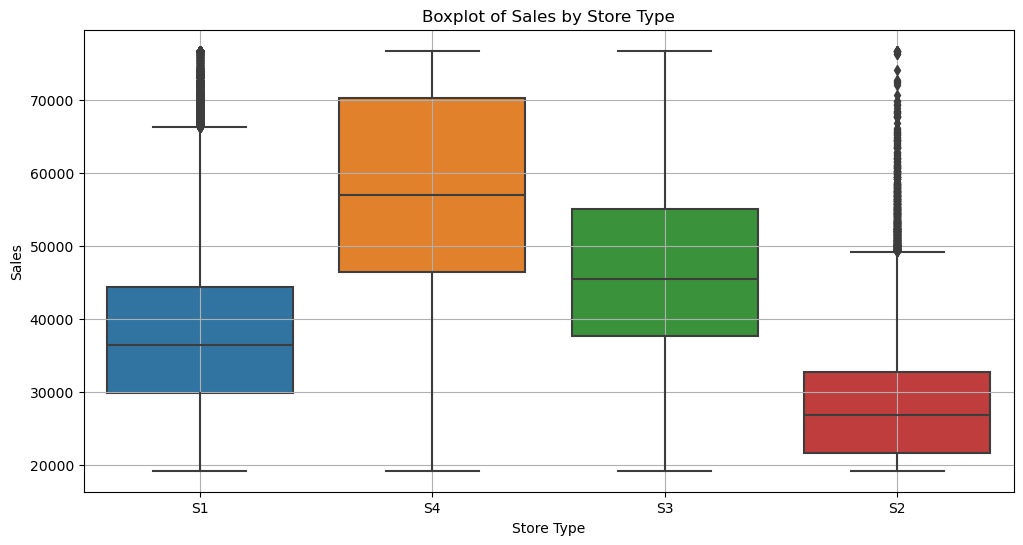

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store_Type', y='Sales', data=train_data)
plt.title('Boxplot of Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

- #### Average sales by Location Type

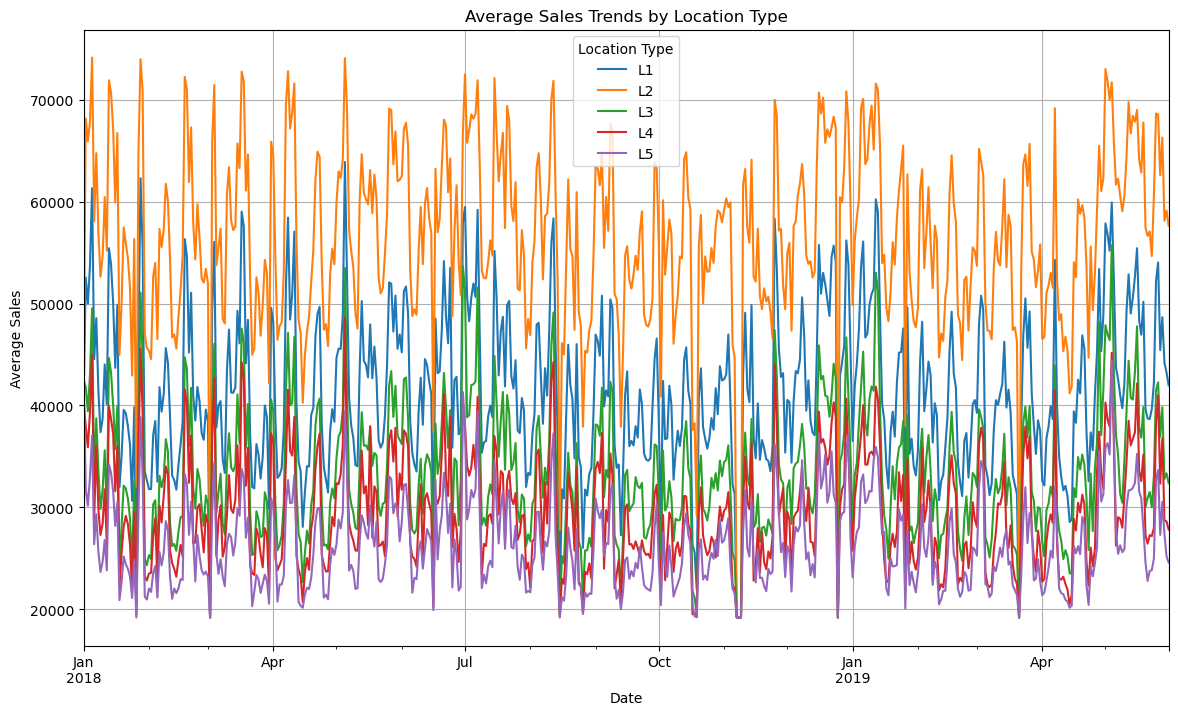

In [15]:
location_type_sales = train_data.groupby(['Date', 'Location_Type'])['Sales'].mean().unstack()

location_type_sales.plot(figsize=(14, 8))
plt.title('Average Sales Trends by Location Type')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend(title='Location Type')
plt.grid(True)
plt.show()

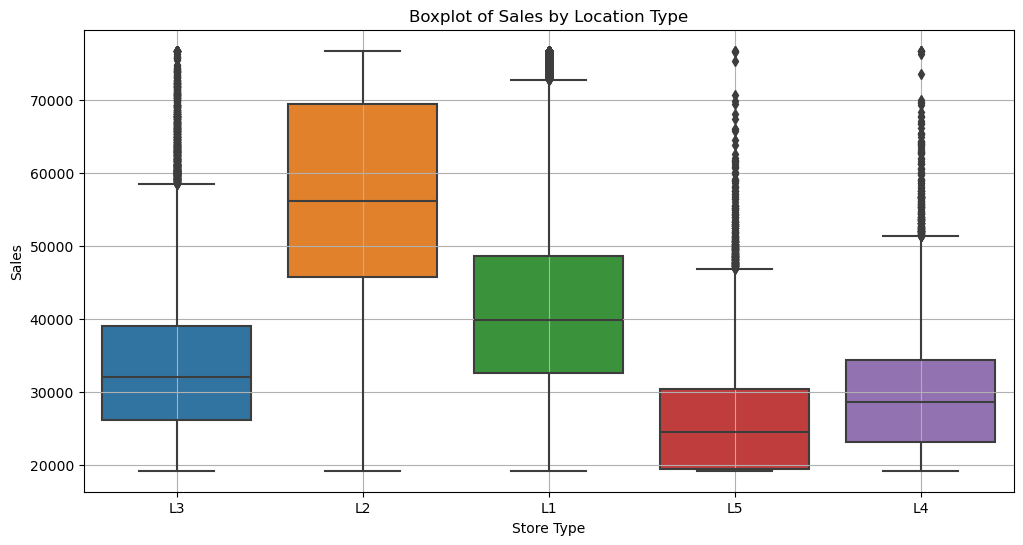

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location_Type', y='Sales', data=train_data)
plt.title('Boxplot of Sales by Location Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

- #### Average sales on holidays vs. non-holidays

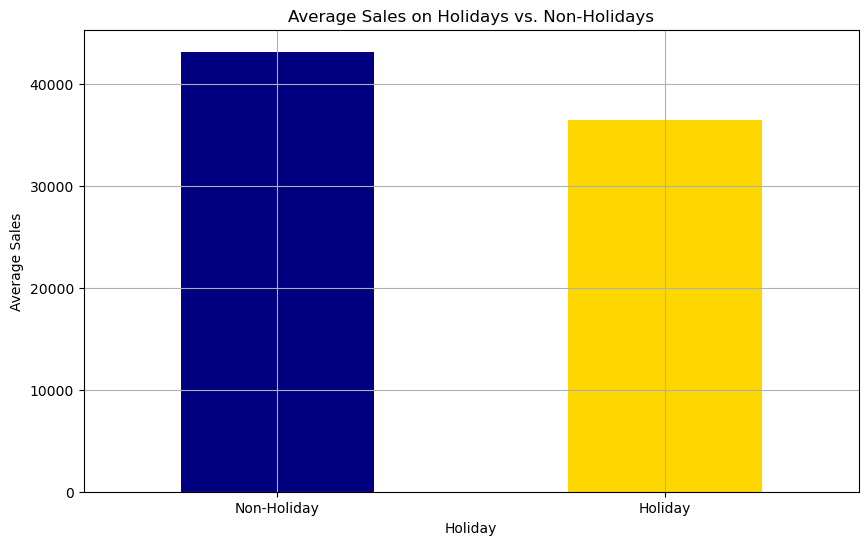

In [17]:
holiday_sales = train_data.groupby('Holiday')['Sales'].mean()

holiday_sales.plot(kind='bar', figsize=(10, 6), color=['navy', 'gold'])
plt.title('Average Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday')
plt.ylabel('Average Sales')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.grid(True)
plt.show()

- #### Average sales with and without discounts

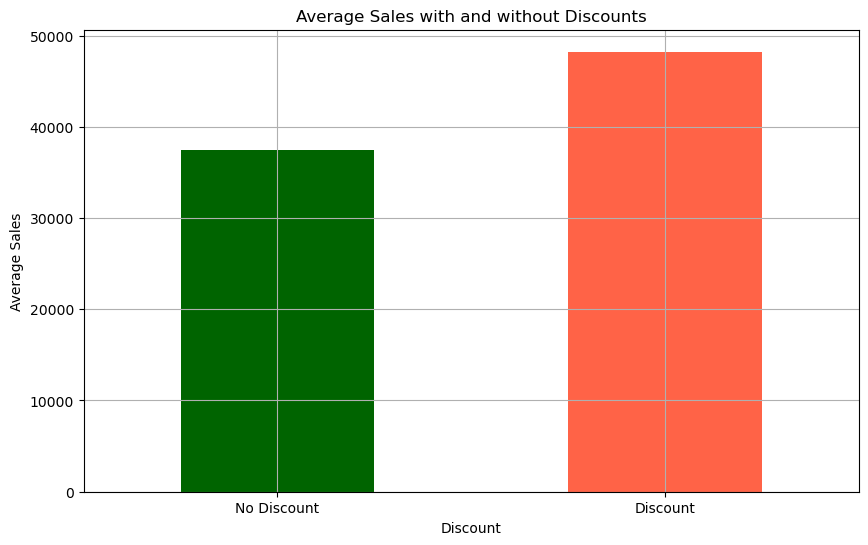

In [18]:
discount_sales = train_data.groupby('Discount')['Sales'].mean()

discount_sales.plot(kind='bar', figsize=(10, 6), color=['darkgreen', 'tomato'])
plt.title('Average Sales with and without Discounts')
plt.xlabel('Discount')
plt.ylabel('Average Sales')
plt.xticks(ticks=[0, 1], labels=['No Discount', 'Discount'], rotation=0)
plt.grid(True)
plt.show()

- #### Average sales on weekends vs. non-weekends

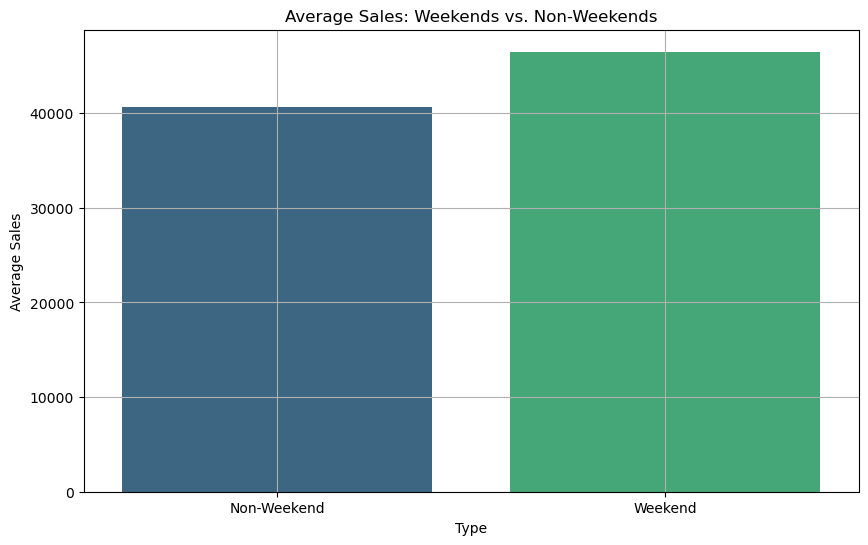

In [19]:
weekend_sales = train_data[train_data['Date'].dt.dayofweek >= 5]['Sales'].mean()
non_weekend_sales = train_data[train_data['Date'].dt.dayofweek < 5]['Sales'].mean()

sales_comparison = pd.DataFrame({
    'Type': ['Non-Weekend', 'Weekend'],
    'Average_Sales': [non_weekend_sales, weekend_sales]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Average_Sales', data=sales_comparison, palette='viridis')
plt.title('Average Sales: Weekends vs. Non-Weekends')
plt.xlabel('Type')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

- #### Average sales by month and by week-day

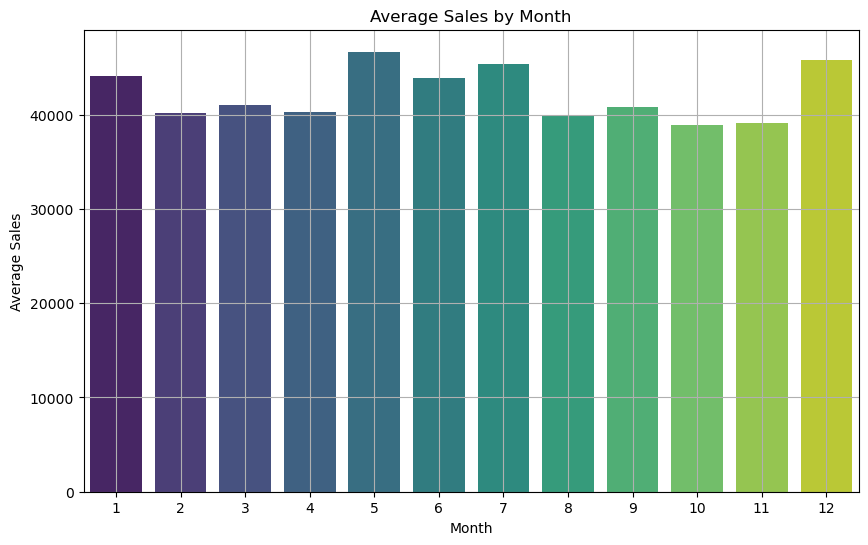

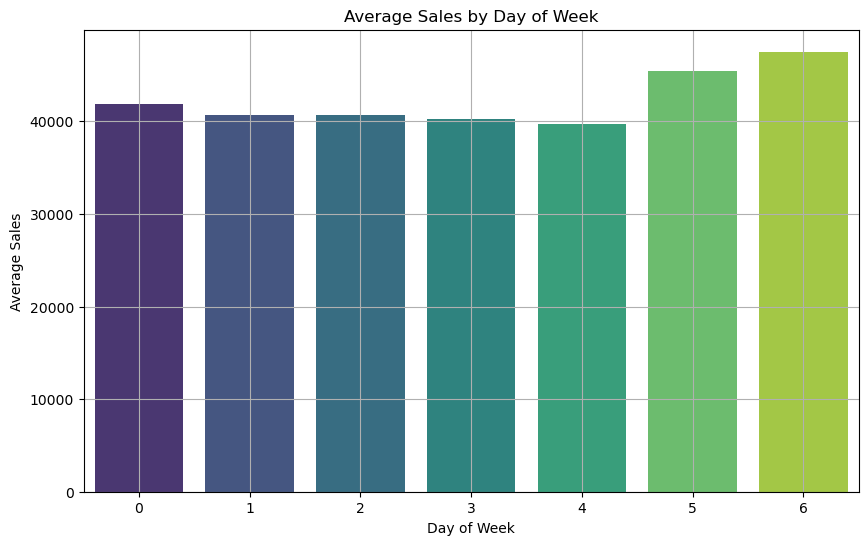

In [20]:
monthly_sales = train_data.groupby(train_data['Date'].dt.month)['Sales'].mean().reset_index()
monthly_sales.columns = ['Month', 'Average_Sales']

plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Average_Sales', data=monthly_sales, palette='viridis')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

weekday_sales = train_data.groupby(train_data['Date'].dt.dayofweek)['Sales'].mean().reset_index()
weekday_sales.columns = ['Day_of_Week', 'Average_Sales']

plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='Average_Sales', data=weekday_sales, palette='viridis')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

- #### Ordes vs. Sales

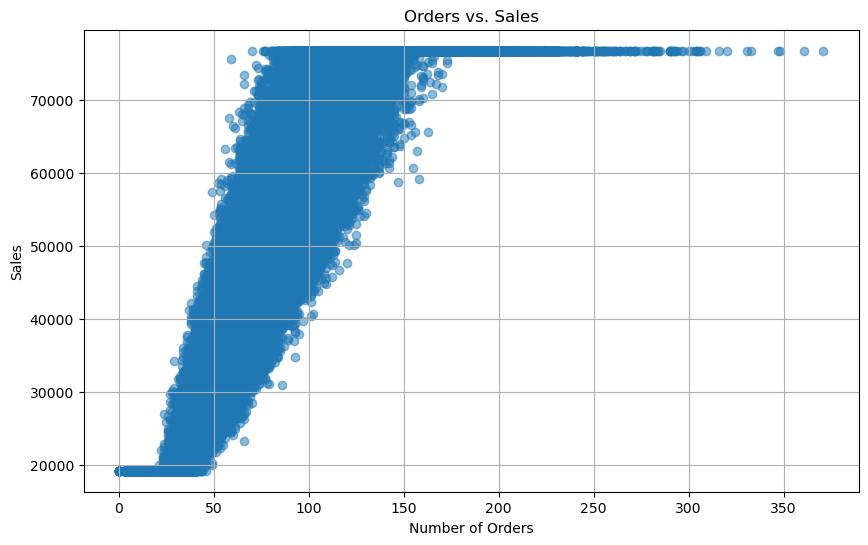

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(train_data['#Order'], train_data['Sales'], alpha=0.5)
plt.title('Orders vs. Sales')
plt.xlabel('Number of Orders')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

***

### Feature Engineering

In [22]:
train_data['Day_of_Week'] = train_data['Date'].dt.dayofweek
train_data['Month'] = train_data['Date'].dt.month
train_data['Year'] = train_data['Date'].dt.year

test_data['Day_of_Week'] = test_data['Date'].dt.dayofweek
test_data['Month'] = test_data['Date'].dt.month
test_data['Year'] = test_data['Date'].dt.year

for lag in [1, 2, 7]:
    train_data[f'Sales_Lag{lag}'] = train_data.groupby('Store_id')['Sales'].shift(lag)

train_data.fillna(0, inplace=True)

# Encode categorical variables
train_data_encoded = pd.get_dummies(train_data, columns=['Store_Type',
                                                         'Location_Type',
                                                         'Region_Code'])
test_data_encoded = pd.get_dummies(test_data, columns=['Store_Type',
                                                       'Location_Type',
                                                       'Region_Code'])

In [23]:
display(train_data_encoded.T)

,0,1,2,3,4,5,6,7,8,9,...,188330,188331,188332,188333,188334,188335,188336,188337,188338,188339
ID,T1000001,T1000002,T1000003,T1000004,T1000005,T1000006,T1000007,T1000008,T1000009,T1000010,...,T1188331,T1188332,T1188333,T1188334,T1188335,T1188336,T1188337,T1188338,T1188339,T1188340
Store_id,1,253,252,251,250,249,248,247,246,254,...,147,31,150,339,151,149,153,154,155,152
Date,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,...,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00,2019-05-31 00:00:00
Holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Discount,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
#Order,9,60,42,23,62,39,40,64,62,87,...,84,48,137,85,38,51,90,56,70,47
Sales,19191.0,51789.12,36868.2,19715.16,45614.52,34211.22,35352.66,52650.0,42633.78,62572.8,...,48026.88,27760.08,76809.0,50018.34,24105.6,37272.0,54572.64,31624.56,49162.41,37977.0
Day_of_Week,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
Month,1,1,1,1,1,1,1,1,1,1,...,5,5,5,5,5,5,5,5,5,5
Year,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019


In [24]:
# Define features and target
# Drop target and irrelevant columns from the feature set
features = [col for col in train_data_encoded.columns if col not in ['ID',
                                                                     'Date',
                                                                     '#Order',
                                                                     'Sales']]
X = train_data_encoded[features]
y = train_data_encoded['Sales']

In [25]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

***

### **Models**
#### Training and Evaluation
**1. Decision Tree** \
**2. Random Forest** \
**3. LightGBM** \
**4. Elastic Net** \
**5. K-Nearest Neighbors (KNN)** \
**6. Gradient Boost** \
**7. CatBoost** \
**8. XGBoost**

In [26]:
scores, maes, mses, rmses, mapes  = {}, {}, {}, {}, {} # Dictionaries to store score and error values

### 1. Decision Tree 

In [27]:
# Model Training
model_dt = DecisionTreeRegressor() 
model_dt.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_dt = model_dt.predict(X_val)

# Score (R^2)
score_dt = model_dt.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_dt = mean_absolute_error(y_val, y_pred_model_dt)

# MSE for validation data
mse_dt = mean_squared_error(y_val, y_pred_model_dt)

# RMSE for validation data
rmse_dt = np.sqrt(mean_squared_error(y_val, y_pred_model_dt))

# MAPE for validation data
mape_dt = mean_absolute_percentage_error(y_val, y_pred_model_dt)

# Store the values in the corresponding dictionaries
scores['Decision Tree'] = score_dt
maes['Decision Tree'] = mae_dt
mses['Decision Tree'] = mse_dt
rmses['Decision Tree'] = rmse_dt
mapes['Decision Tree'] = mape_dt

In [28]:
print(f'Decision Tree Model\nScore (R^2): {score_dt}\nMean Absolute Error: {mae_dt}\n\
Mean Squared Error: {mse_dt}\nRoot Mean Squared Error: {rmse_dt}\n\
Mean Absolute Percentage Error: {mape_dt}')

Decision Tree Model
Score (R^2): 0.6427992823525552
Mean Absolute Error: 6366.875896782415
Mean Squared Error: 87097966.91863471
Root Mean Squared Error: 9332.62915360054
Mean Absolute Percentage Error: 0.1597289041564934


### 2. Random Forest 

In [29]:
# Model Training
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_rf = model_rf.predict(X_val)

# Score (R^2)
score_rf = model_rf.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_rf = mean_absolute_error(y_val, y_pred_model_rf)

# MSE for validation data
mse_rf = mean_squared_error(y_val, y_pred_model_rf)

# RMSE for validation data
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_model_rf))

# MAPE for validation data
mape_rf = mean_absolute_percentage_error(y_val, y_pred_model_rf)

# Store the values in the corresponding dictionaries
scores['Random Forest'] = score_rf
maes['Random Forest'] = mae_rf
mses['Random Forest'] = mse_rf
rmses['Random Forest'] = rmse_rf
mapes['Random Forest'] = mape_rf

In [30]:
print(f'Random Forest Model\nScore (R^2): {score_rf}\nMean Absolute Error: {mae_rf}\n\
Mean Squared Error: {mse_rf}\nRoot Mean Squared Error: {rmse_rf}\n\
Mean Absolute Percentage Error: {mape_rf}')

Random Forest Model
Score (R^2): 0.8246203273642222
Mean Absolute Error: 4628.946276680851
Mean Squared Error: 42763668.07445364
Root Mean Squared Error: 6539.393555556481
Mean Absolute Percentage Error: 0.11826725398210279


### 3. LightGBM

In [31]:
# Model Training
model_gbm = lgb.LGBMRegressor(n_estimators=100, max_depth=3, random_state=100)
model_gbm.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_gbm = model_gbm.predict(X_val)

# Score (R^2)
score_gbm = model_gbm.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_gbm = mean_absolute_error(y_val, y_pred_model_gbm)

# MSE for validation data
mse_gbm = mean_squared_error(y_val, y_pred_model_gbm)

# RMSE for validation data
rmse_gbm = np.sqrt(mean_squared_error(y_val, y_pred_model_gbm))

# MAPE for validation data
mape_gbm = mean_absolute_percentage_error(y_val, y_pred_model_gbm)

# Store the values in the corresponding dictionaries
scores['LightGBM'] = score_gbm
maes['LightGBM'] = mae_gbm
mses['LightGBM'] = mse_gbm
rmses['LightGBM'] = rmse_gbm
mapes['LightGBM'] = mape_gbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 22
[LightGBM] [Info] Start training from score 42274.395829


In [32]:
print(f'LightGBM Model\nScore (R^2): {score_gbm}\nMean Absolute Error: {mae_gbm}\n\
Mean Squared Error: {mse_gbm}\nRoot Mean Squared Error: {rmse_gbm}\n\
Mean Absolute Percentage Error: {mape_gbm}')

LightGBM Model
Score (R^2): 0.7528766470148474
Mean Absolute Error: 5657.750542159516
Mean Squared Error: 60257274.2991153
Root Mean Squared Error: 7762.555912785125
Mean Absolute Percentage Error: 0.1483591767632201


### 4. Elastic Net 

In [33]:
# Model Training
model_en = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
model_en.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_en = model_en.predict(X_val)

# Score (R^2)
score_en = model_en.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_en = mean_absolute_error(y_val, y_pred_model_en)

# MSE for validation data
mse_en = mean_squared_error(y_val, y_pred_model_en)

# RMSE for validation data
rmse_en = np.sqrt(mean_squared_error(y_val, y_pred_model_en))

# MAPE for validation data
mape_en = mean_absolute_percentage_error(y_val, y_pred_model_en)

# Store the values in the corresponding dictionaries
scores['Elastic Net'] = score_en
maes['Elastic Net'] = mae_en
mses['Elastic Net'] = mse_en
rmses['Elastic Net'] = rmse_en
mapes['Elastic Net'] = mape_en

In [34]:
print(f'Elastic Net Model\nScore (R^2): {score_en}\nMean Absolute Error: {mae_en}\n\
Mean Squared Error: {mse_en}\nRoot Mean Squared Error: {rmse_en}\n\
Mean Absolute Percentage Error: {mape_en}')

Elastic Net Model
Score (R^2): 0.614864847944513
Mean Absolute Error: 7017.383355742589
Mean Squared Error: 93909354.25286683
Root Mean Squared Error: 9690.683889843216
Mean Absolute Percentage Error: 0.18841273859263646


### 5. K-Nearest Neighbors (KNN) 

In [35]:
# Create a pipeline with scaling and KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),  # Or MinMaxScaler()
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Model Training
pipeline_knn.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_knn = pipeline_knn.predict(X_val)

# Score (R^2)
score_knn = pipeline_knn.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_knn = mean_absolute_error(y_val, y_pred_model_knn)

# MSE for validation data
mse_knn = mean_squared_error(y_val, y_pred_model_knn)

# RMSE for validation data
rmse_knn = np.sqrt(mean_squared_error(y_val, y_pred_model_knn))

# MAPE for validation data
mape_knn = mean_absolute_percentage_error(y_val, y_pred_model_knn)

# Store the values in the corresponding dictionaries
scores['KNN'] = score_knn
maes['KNN'] = mae_knn
mses['KNN'] = mse_knn
rmses['KNN'] = rmse_knn
mapes['KNN'] = mape_knn

In [36]:
print(f'KNN Model\nScore (R^2): {score_knn}\nMean Absolute Error: {mae_knn}\n\
Mean Squared Error: {mse_knn}\nRoot Mean Squared Error: {rmse_knn}\n\
Mean Absolute Percentage Error: {mape_knn}')

KNN Model
Score (R^2): 0.7598692119557277
Mean Absolute Error: 5495.9914402676
Mean Squared Error: 58552243.598425835
Root Mean Squared Error: 7651.943779094684
Mean Absolute Percentage Error: 0.1395105095311109


### 6. Gradient Boost

In [37]:
# Model Training
model_gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=100)
model_gb.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_gb = model_gb.predict(X_val)

# Score (R^2)
score_gb = model_gb.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_gb = mean_absolute_error(y_val, y_pred_model_gb)

# MSE for validation data
mse_gb = mean_squared_error(y_val, y_pred_model_gb)

# RMSE for validation data
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_model_gb))

# MAPE for validation data
mape_gb = mean_absolute_percentage_error(y_val, y_pred_model_gb)

# Store the values in the corresponding dictionaries
scores['Gradient Boost'] = score_gb
maes['Gradient Boost'] = mae_gb
mses['Gradient Boost'] = mse_gb
rmses['Gradient Boost'] = rmse_gb
mapes['Gradient Boost'] = mape_gb

In [38]:
print(f'Gradient Boosting Model\nScore (R^2): {score_gb}\nMean Absolute Error :{mae_gb}\n\
Mean Squared Error: {mse_gb}\nRoot Mean Squared Error: {rmse_gb}\n\
Mean Absolute Percentage Error: {mape_gb}')

Gradient Boosting Model
Score (R^2): 0.7533768803124771
Mean Absolute Error :5655.285345966377
Mean Squared Error: 60135300.01111413
Root Mean Squared Error: 7754.695352566348
Mean Absolute Percentage Error: 0.14815664947153614


### 7. CatBoost

In [39]:
# Model Training
model_cb = cb.CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='MAE', random_seed=42, verbose=0)
model_cb.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_cb = model_cb.predict(X_val)

# Score (R^2)
score_cb = model_cb.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_cb = mean_absolute_error(y_val, y_pred_model_cb)

# MSE for validation data
mse_cb = mean_squared_error(y_val, y_pred_model_cb)

# RMSE for validation data
rmse_cb = np.sqrt(mean_squared_error(y_val, y_pred_model_cb))

# MAPE for validation data
mape_cb = mean_absolute_percentage_error(y_val, y_pred_model_cb)

# Store the values in the corresponding dictionaries
scores['CatBoost'] = score_cb
maes['CatBoost'] = mae_cb
mses['CatBoost'] = mse_cb
rmses['CatBoost'] = rmse_cb
mapes['CatBoost'] = mape_cb

In [40]:
print(f'CatBoost Model\nScore (R^2): {score_cb}\nMean Absolute Error: {mae_cb}\n\
Mean Squared Error: {mse_cb}\nRoot Mean Squared Error: {rmse_cb}\n\
Mean Absolute Percentage Error: {mape_cb}')

CatBoost Model
Score (R^2): 0.8109348198836519
Mean Absolute Error: 4619.179569138755
Mean Squared Error: 46100671.1064126
Root Mean Squared Error: 6789.74749945921
Mean Absolute Percentage Error: 0.11840367890912822


### 8. XGBoost

In [41]:
# Model Training
model_xgb = xg.XGBRegressor(n_estimators = 500, seed = 100)
model_xgb.fit(X_train, y_train)

# Prediction for validation set
y_pred_model_xgb = model_xgb.predict(X_val)

# Score (R^2)
score_xgb = model_xgb.score(X_val, y_val)

# Errors:
# MAE for validation data
mae_xgb = mean_absolute_error(y_val, y_pred_model_xgb)

# MSE for validation data
mse_xgb = mean_squared_error(y_val, y_pred_model_xgb)

# RMSE for validation data
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_model_xgb))

# MAPE for validation data
mape_xgb = mean_absolute_percentage_error(y_val, y_pred_model_xgb)

# Store the values in the corresponding dictionaries
scores['XGBoost'] = score_xgb
maes['XGBoost'] = mae_xgb
mses['XGBoost'] = mse_xgb
rmses['XGBoost'] = rmse_xgb
mapes['XGBoost'] = mape_xgb

In [42]:
print(f'XGBoost Model\nScore (R^2): {score_xgb}\nMean Absolute Error :{mae_xgb}\n\
Mean Squared Error: {mse_xgb}\nRoot Mean Squared Error: {rmse_xgb}\n\
Mean Absolute Percentage Error: {mape_xgb}')

XGBoost Model
Score (R^2): 0.8480154376755993
Mean Absolute Error :4395.614572222692
Mean Squared Error: 37059125.94089248
Root Mean Squared Error: 6087.620712634163
Mean Absolute Percentage Error: 0.11199403375582385


***

#### Evaluation

In [43]:
df_scores = pd.DataFrame.from_dict(scores, columns = ['Score (R²)'], orient = 'index')
df_maes = pd.DataFrame.from_dict(maes, columns = ['Mean Absolute Error (MAE)'], orient = 'index')
df_mses = pd.DataFrame.from_dict(mses, columns = ['Mean Squared Error (MSE)'], orient = 'index')
df_rmses = pd.DataFrame.from_dict(rmses, columns = ['Root Mean Absolute Error (RMSE)'], orient = 'index')
df_mapes = pd.DataFrame.from_dict(mapes, columns = ['Mean Absolute Percentage Error (MAPE)'], orient = 'index')

evaluation_df = pd.concat([df_scores,
                           df_maes,
                           df_mses,
                           df_rmses,
                           df_mapes], axis=1)

In [44]:
display(evaluation_df)

,Score (R²),Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Absolute Error (RMSE),Mean Absolute Percentage Error (MAPE)
Decision Tree,0.642799,6366.875897,8.709797e+07,9332.629154,0.159729
Random Forest,0.824620,4628.946277,4.276367e+07,6539.393556,0.118267
LightGBM,0.752877,5657.750542,6.025727e+07,7762.555913,0.148359
Elastic Net,0.614865,7017.383356,9.390935e+07,9690.683890,0.188413
KNN,0.759869,5495.991440,5.855224e+07,7651.943779,0.139511
Gradient Boost,0.753377,5655.285346,6.013530e+07,7754.695353,0.148157
CatBoost,0.810935,4619.179569,4.610067e+07,6789.747499,0.118404
XGBoost,0.848015,4395.614572,3.705913e+07,6087.620713,0.111994


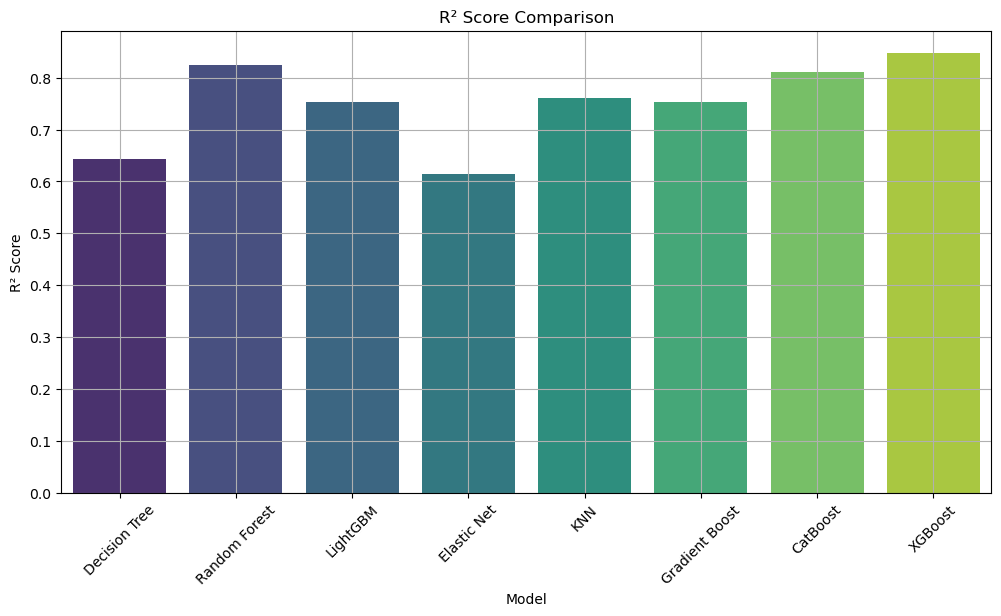

In [45]:
# Bar plot for R² Score
plt.figure(figsize=(12, 6))
sns.barplot(x=evaluation_df.index,
            y='Score (R²)',
            data=evaluation_df,
            palette='viridis')
plt.title('R² Score Comparison')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

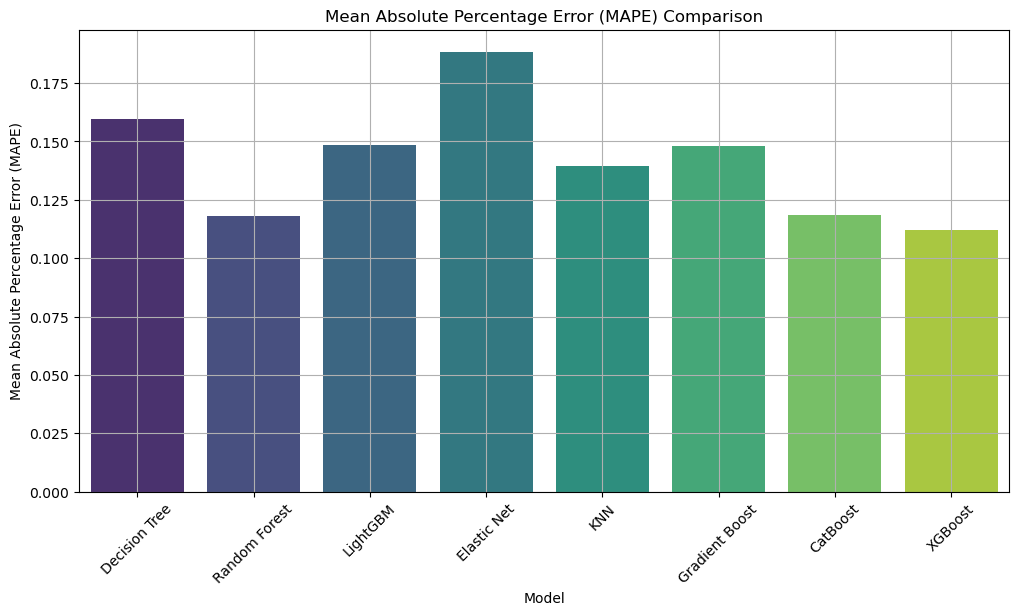

In [46]:
# Bar plot for MAPE
plt.figure(figsize=(12, 6))
sns.barplot(x=evaluation_df.index,
            y='Mean Absolute Percentage Error (MAPE)',
            data=evaluation_df,
            palette='viridis')
plt.title('Mean Absolute Percentage Error (MAPE) Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Choosing XGBoost for Sales Forecasting

After evaluating various regression models on the training dataset, XGBoost emerged as the best-performing model for sales forecasting. Here are the key reasons for selecting XGBoost:

**High R² Score:**

- XGBoost achieved the highest R² score of 0.848, indicating that it explains 84.8% of the variance in the sales data. This demonstrates the model's strong ability to capture the underlying patterns and trends in the dataset.

**Low Mean Absolute Error (MAE):**

- With an MAE of 4395.61, XGBoost has the lowest average prediction error among all models. This means that, on average, the predicted sales values are very close to the actual sales values, leading to more accurate forecasts.

**Low Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):**

- XGBoost also has the lowest MSE (3.71e+07) and RMSE (6087.62), indicating that it has the smallest squared and root squared prediction errors. These metrics highlight the model's robustness and accuracy, especially in the presence of large errors.

**Reasonable Mean Absolute Percentage Error (MAPE):**

- The MAPE of XGBoost is 0.111994 (or approximately 11.2%), which is the lowest among the evaluated models. This metric provides an intuitive understanding of the prediction accuracy in percentage terms and confirms that XGBoost delivers precise forecasts relative to the actual sales values.

**Overall Performance:**

- In addition to the specific error metrics, XGBoost consistently performed well across all evaluation criteria, making it a reliable and robust choice for sales forecasting.

#### Conclusion

Given its superior performance across all key metrics, XGBoost is selected as the final model for predicting future sales. Its ability to accurately capture complex patterns in the data makes it well-suited for this task. The next steps involve training the XGBoost model on the entire training dataset and making predictions on the test dataset to generate the final sales forecasts.


***

### Forecasting

**Key Points:**
- Lag Features in Training Data: These features are crucial for capturing temporal dependencies and are included in the model training process.
- Lag Features in Test Data: Since we don't have historical sales data for future dates, we need to iteratively predict and update the test data to generate lag features for subsequent predictions.


#### Model's perfomance on validation set when lags are computed from predicted sales in an iterative approach

In [47]:
feature_list = ['Store_id',
                'Holiday',
                'Discount',
                'Day_of_Week',
                'Month',
                'Year',
                'Store_Type_S1',
                'Store_Type_S2',
                'Store_Type_S3',
                'Store_Type_S4',
                'Location_Type_L1',
                'Location_Type_L2',
                'Location_Type_L3',
                'Location_Type_L4',
                'Location_Type_L5',
                'Region_Code_R1',
                'Region_Code_R2',
                'Region_Code_R3',
                'Region_Code_R4',
                'Sales_Lag1',
                'Sales_Lag2',
                'Sales_Lag7']

In [48]:
# Split data chronologically
train_data_encoded = train_data_encoded.sort_values('Date')
split_index = int(len(train_data_encoded) * 0.8)
train_set = train_data_encoded.iloc[:split_index].copy()
validation_set = train_data_encoded.iloc[split_index:].copy()

val =  validation_set.copy()
validation_set_1 =  validation_set.copy()

# Initialize lag features in validation set to zero
validation_set.loc[:, 'Sales'] = 0.0  # Initialize sales with zero
for lag in ['Sales_Lag1', 'Sales_Lag2', 'Sales_Lag7']:
    validation_set.loc[:, lag] = 0.0  # Initialize lag features with zero

# Update the initial lag values with the last known sales values from the training data
# For the first week of the validation dates
for store_id in validation_set['Store_id'].unique():
    if store_id in train_set['Store_id'].unique():
        
        # Get the last 7 days of sales for the current store from the training data
        last_7_days_sales = train_set[train_set['Store_id'] == store_id]['Sales'].tail(7).tolist()
        
        # Initialize lag features for the first week in the validation data for the current store
        val_store_data = validation_set[validation_set['Store_id'] == store_id]
        
        # Get the first week's validation days for the current store
        first_week = val_store_data['Date'].sort_values().unique()[:7]

        # Update Sales_Lag1, Lag2, and Lag7 for the first validation day from the last train days
        if len(first_week) >= 1:
            first_val_day = first_week[0]
            for lag in [1, 2, 7]:
                if len(last_7_days_sales) >= lag:
                    validation_set.loc[
                        (validation_set['Store_id'] == store_id) & (validation_set['Date'] == first_val_day), 
                        f'Sales_Lag{lag}'
                    ] = last_7_days_sales[-lag]
        
        if len(first_week) >= 2:
            second_val_day = first_week[1]
            
            # Update Sales_Lag2 for the second day (same as Sales_Lag1 from the first day)
            sales_lag1_first_day = validation_set.loc[
                (validation_set['Store_id'] == store_id) & (validation_set['Date'] == first_val_day), 
                'Sales_Lag1'
            ].values[0]
            
            validation_set.loc[
                (validation_set['Store_id'] == store_id) & (validation_set['Date'] == second_val_day), 
                'Sales_Lag2'
            ] = sales_lag1_first_day
            
            # Update Sales_Lag7 for the second day (6 days ago from the end of training data)
            if len(last_7_days_sales) >= 6:
                validation_set.loc[
                    (validation_set['Store_id'] == store_id) & (validation_set['Date'] == second_val_day), 
                    'Sales_Lag7'
                ] = last_7_days_sales[-6]
        
        for i in range(2, min(len(first_week), 7)):
            val_day = first_week[i]
            # Update Sales_Lag7 for the third to seventh days (5, 4, 3, 2, 1 days ago from the end of training data)
            if len(last_7_days_sales) >= (7 - i):
                validation_set.loc[
                    (validation_set['Store_id'] == store_id) & (validation_set['Date'] == val_day), 
                    'Sales_Lag7'
                ] = last_7_days_sales[-(7 - i)]

# Function to predict and update lags
def predict_and_update_lags(best_model, data_encoded, feature_list):
    """
    Predict sales for each row in the data and update lag features.

    Parameters:
    - best_model: Trained XGBoost model.
    - data_encoded: DataFrame containing data with encoded features.
    - feature_list: List of features used for prediction, ensuring correct order.

    This function iterates through each store's data, makes sales predictions,
    updates the 'Sales' column, and adjusts the lag features for subsequent rows.
    """
    predictions = []

    for store_id in data_encoded['Store_id'].unique():
        store_data = data_encoded[data_encoded['Store_id'] == store_id]
        for i in range(len(store_data)):
            current_test_row = store_data.iloc[i:i+1]
            current_test_row = current_test_row[feature_list]  # Ensure correct feature order
            current_prediction = best_model.predict(current_test_row)
            
            # Store the prediction
            predictions.append((current_test_row.index[0], current_prediction[0]))
            
            # Update the 'Sales' column in the data with the current prediction
            data_encoded.at[current_test_row.index[0], 'Sales'] = float(current_prediction[0])
            
            # Update lag features for subsequent rows
            if i + 1 < len(store_data):
                if data_encoded.at[store_data.index[i + 1], 'Sales_Lag1'] == 0:
                    data_encoded.at[store_data.index[i + 1], 'Sales_Lag1'] = float(current_prediction[0])
            if i + 2 < len(store_data):
                if data_encoded.at[store_data.index[i + 2], 'Sales_Lag2'] == 0:
                    data_encoded.at[store_data.index[i + 2], 'Sales_Lag2'] = float(current_prediction[0])
            if i + 7 < len(store_data):
                if data_encoded.at[store_data.index[i + 7], 'Sales_Lag7'] == 0:
                    data_encoded.at[store_data.index[i + 7], 'Sales_Lag7'] = float(current_prediction[0])

    return predictions

# Prepare the training data
X_train = train_set[feature_list]
y_train = train_set['Sales']

# Train the model on the training set
best_model = xg.XGBRegressor(n_estimators=500, seed=100)
best_model.fit(X_train, y_train)

# Perform iterative prediction on the validation set
validation_predictions = predict_and_update_lags(best_model, validation_set_1, feature_list)

In [49]:
pred_df = validation_set_1[['ID', 'Sales', 'Date']].copy()
actual_sales_df = val[['ID', 'Sales', 'Date']].copy()

merged_df = pd.merge(pred_df, actual_sales_df, on=['ID', 'Date'], how='left', suffixes=('_pred', '_actual'))

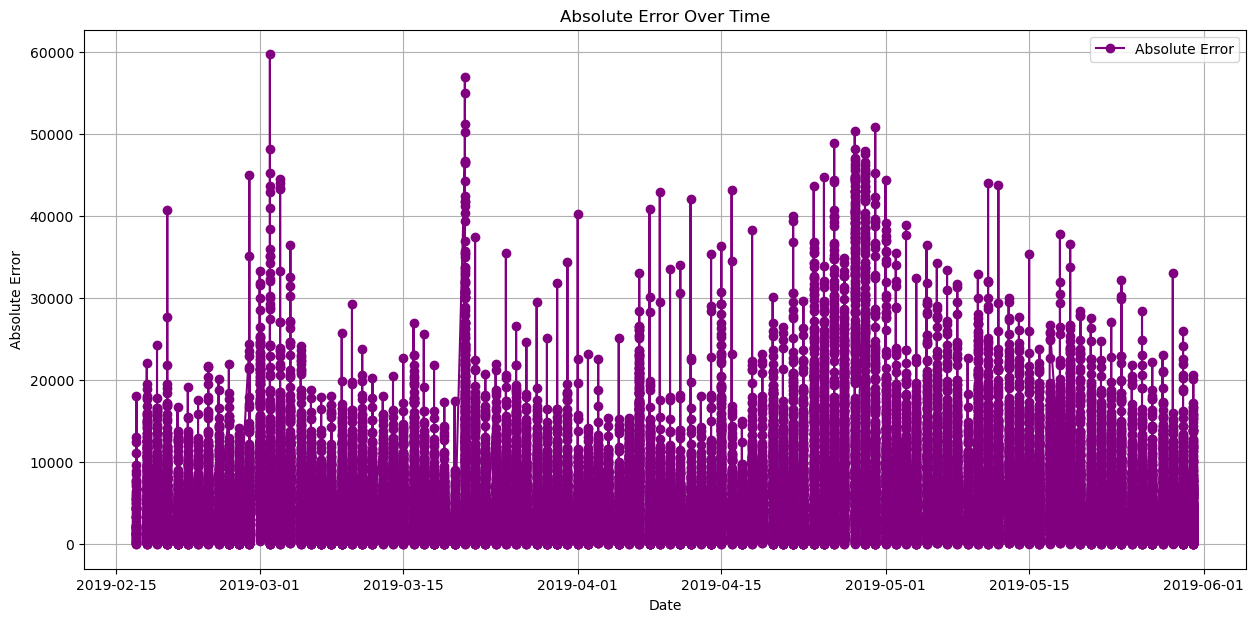

In [50]:
# Calculate absolute error
merged_df['Error'] = (merged_df['Sales_actual'] - merged_df['Sales_pred']).abs()
import matplotlib.pyplot as plt

merged_df['Date'] = pd.to_datetime(merged_df['Date'])

plt.figure(figsize=(15, 7))
plt.plot(merged_df['Date'],
         merged_df['Error'],
         label='Absolute Error',
         color='purple',
         marker='o',
         linestyle='-')
plt.title('Absolute Error Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

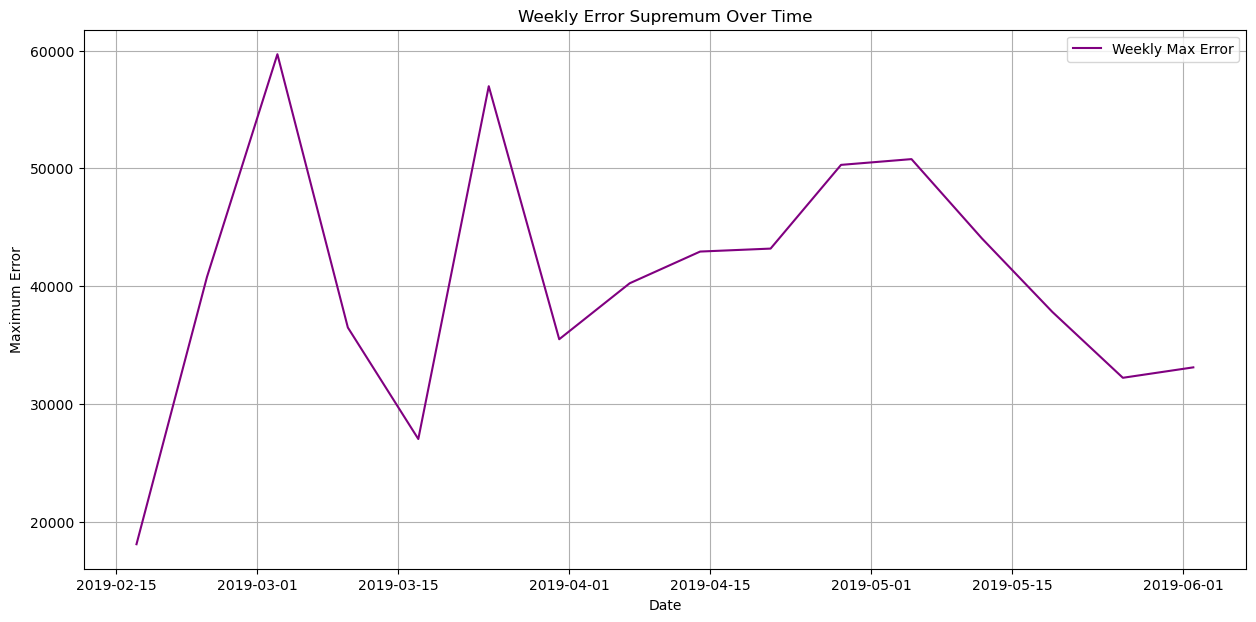

In [51]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

weekly_max_error = merged_df['Error'].resample('W').max()
plt.figure(figsize=(15, 7))
plt.plot(weekly_max_error.index,
         weekly_max_error,
         '-',
         color='purple',
         label='Weekly Max Error')
plt.title('Weekly Error Supremum Over Time')
plt.xlabel('Date')
plt.ylabel('Maximum Error')
plt.legend()
plt.grid(True)
plt.show()

#### Predictions vs Real Values **Overview**

,Date,Sales_actual,Sales_pred
133,2019-02-18,32070.00,37022.027344
521,2019-02-19,31107.90,32809.394531
1081,2019-02-20,36735.00,38354.359375
1471,2019-02-21,43452.00,43008.070312
1681,2019-02-22,19191.00,23039.384766
...,...,...,...
36037,2019-05-27,33075.00,40027.050781
36356,2019-05-28,37317.00,39988.699219
36858,2019-05-29,44652.00,42589.164062
37064,2019-05-30,42387.00,47206.468750


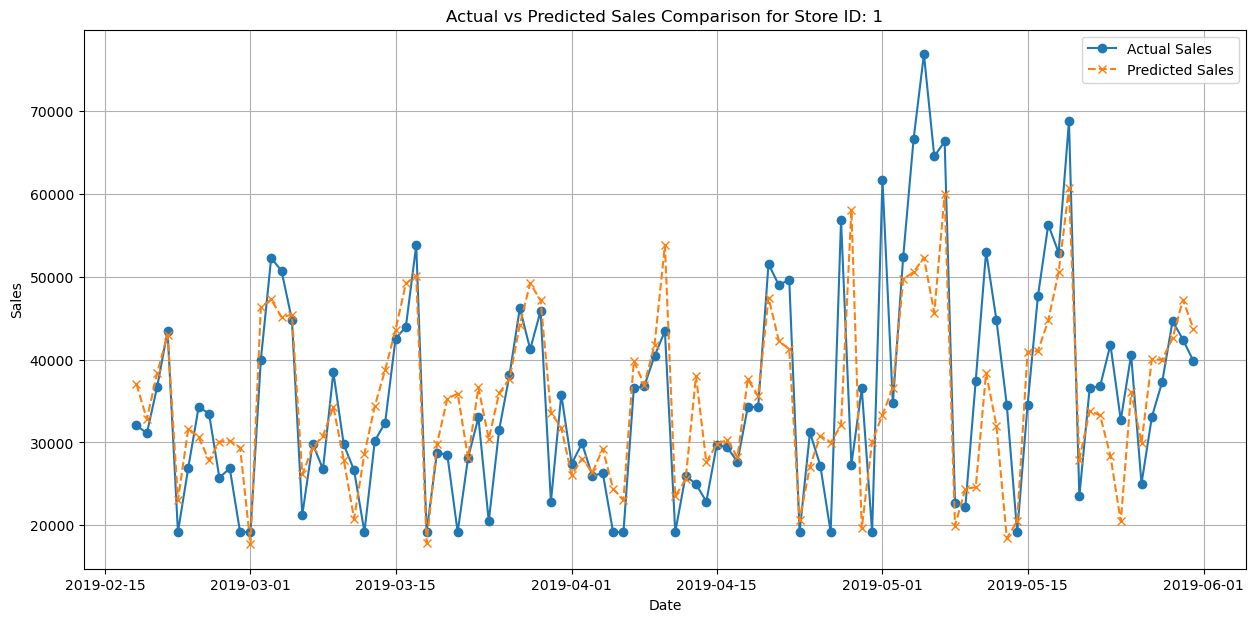

In [52]:
pred_df = validation_set_1[['ID', 'Store_id', 'Sales', 'Date']].copy()
actual_sales_df = val[['ID', 'Store_id', 'Sales', 'Date']].copy()
merged_df = pd.merge(pred_df, actual_sales_df, on=['ID',
                                                   'Date',
                                                   'Store_id'],
                     how='left',
                     suffixes=('_pred', '_actual'))

specific_store_id = 1  

# Filter for the specific store ID
store_specific_df = merged_df[merged_df['Store_id'] == specific_store_id].copy()

store_specific_df['Date'] = pd.to_datetime(store_specific_df['Date'])
store_specific_df = store_specific_df.sort_values('Date')

store_sales_comparison_df = store_specific_df[['Date',
                                               'Sales_actual',
                                               'Sales_pred']]
display(store_sales_comparison_df)

plt.figure(figsize=(15, 7))
plt.plot(store_specific_df['Date'],
         store_specific_df['Sales_actual'],
         label='Actual Sales',
         marker='o')
plt.plot(store_specific_df['Date'],
         store_specific_df['Sales_pred'],
         label='Predicted Sales',
         linestyle='--',
         marker='x')
plt.title(f'Actual vs Predicted Sales Comparison for Store ID: {specific_store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

,Date,Sales_actual,Sales_pred
201,2019-02-18,29784.00,30084.365234
769,2019-02-19,29784.00,31722.992188
1102,2019-02-20,31755.00,31324.000000
1525,2019-02-21,28050.00,32483.191406
1839,2019-02-22,32322.00,30892.769531
...,...,...,...
35902,2019-05-27,31437.00,33104.937500
36230,2019-05-28,33327.00,40411.371094
36896,2019-05-29,30873.00,35268.062500
37249,2019-05-30,32418.00,33636.332031


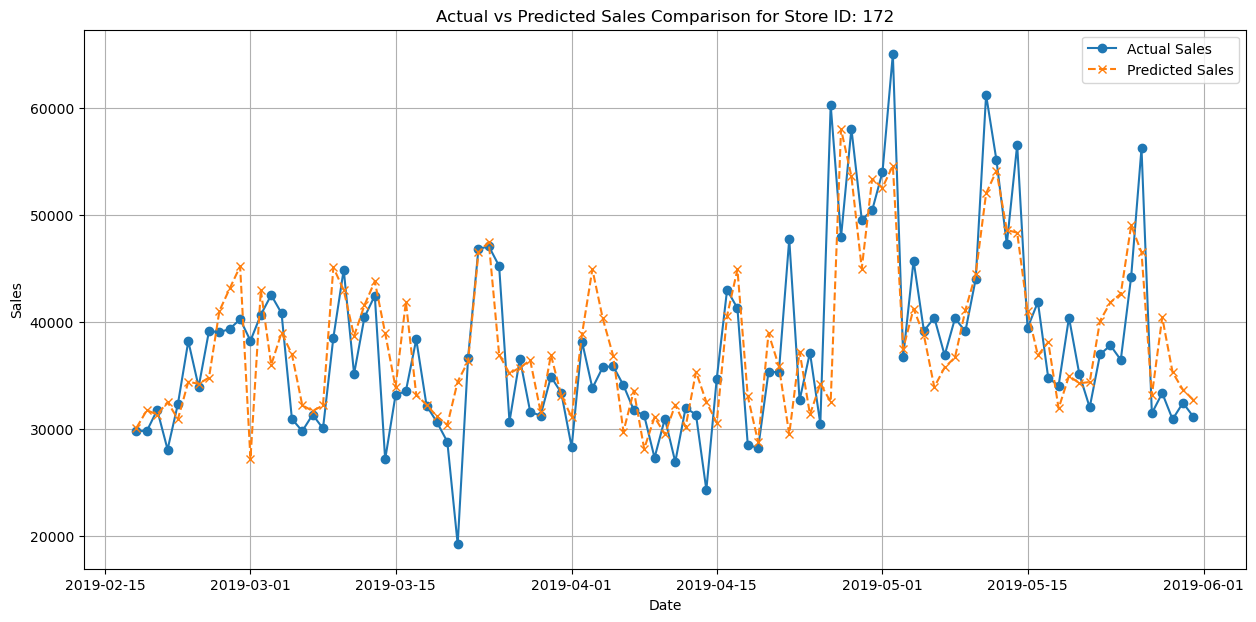

In [53]:
# Include 'Store_id' in the DataFrame used for plotting and analysis
pred_df = validation_set_1[['ID', 'Store_id', 'Sales', 'Date']].copy()
actual_sales_df = val[['ID', 'Store_id', 'Sales', 'Date']].copy()
merged_df = pd.merge(pred_df, actual_sales_df, on=['ID', 'Date','Store_id'], how='left', suffixes=('_pred', '_actual'))

specific_store_id = 172

store_specific_df = merged_df[merged_df['Store_id'] == specific_store_id].copy()

store_specific_df['Date'] = pd.to_datetime(store_specific_df['Date'])
store_specific_df = store_specific_df.sort_values('Date')

store_sales_comparison_df = store_specific_df[['Date', 'Sales_actual', 'Sales_pred']]
display(store_sales_comparison_df)

plt.figure(figsize=(15, 7))
plt.plot(store_specific_df['Date'], store_specific_df['Sales_actual'], label='Actual Sales', marker='o')
plt.plot(store_specific_df['Date'], store_specific_df['Sales_pred'], label='Predicted Sales', linestyle='--', marker='x')
plt.title(f'Actual vs Predicted Sales Comparison for Store ID: {specific_store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
pred_df = validation_set_1[['ID', 'Sales']].copy()
actual_sales_df = val[['ID', 'Sales']].copy()
merged_df = pd.merge(pred_df, actual_sales_df, on='ID', how='left')

In [55]:
merged_df.rename(columns={'Sales_x':'Predicted_Sales','Sales_y':'Actual_Sales'}, inplace=True)

In [56]:
# Calculate validation metrics
r2 = r2_score(merged_df['Actual_Sales'], merged_df['Predicted_Sales'])
mae = mean_absolute_error(merged_df['Actual_Sales'], merged_df['Predicted_Sales'])
mse = mean_squared_error(merged_df['Actual_Sales'], merged_df['Predicted_Sales'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(merged_df['Actual_Sales'], merged_df['Predicted_Sales'])

In [57]:
r2

0.7433416169736293

In [58]:
mae

5725.648457214803

In [59]:
mse

66053936.628415816

In [60]:
rmse

8127.357296711879

In [61]:
mape

0.14290271477623329

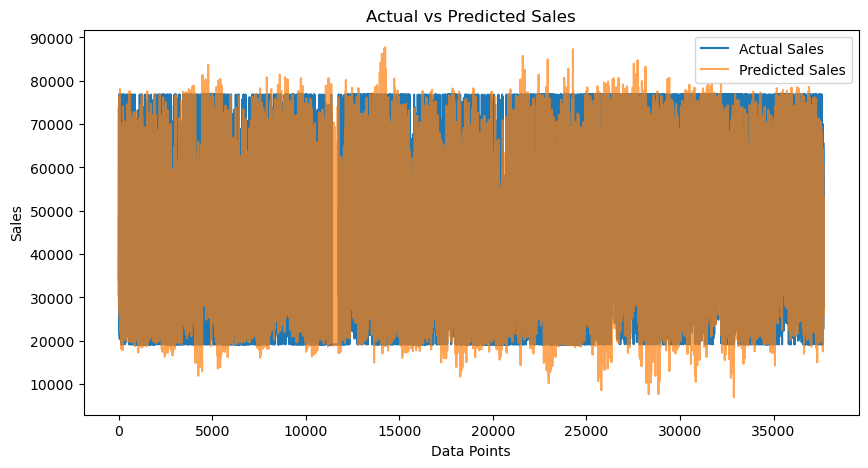

In [62]:
# Plot actual vs predicted sales
plt.figure(figsize=(10, 5))
plt.plot(merged_df['Actual_Sales'], label='Actual Sales')
plt.plot(merged_df['Predicted_Sales'], label='Predicted Sales', alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Data Points')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [63]:
merged_df.head(30)

,ID,Predicted_Sales,Actual_Sales
0,T1150522,33915.320312,33837.0
1,T1150521,53904.972656,71976.0
2,T1150520,29067.587891,30372.0
3,T1150472,73621.039062,73869.0
4,T1150519,69423.500000,63177.0
5,T1150540,66066.070312,52998.0
6,T1150542,47979.433594,48912.0
7,T1150561,41000.136719,37599.0
8,T1150560,46741.214844,46848.0
9,T1150559,38681.468750,33231.0


***

### On Test set

**Approach:**
- Training Data Preparation: we will include lag features in the training data.
- Model Training: We will use the training data with lag features to train the model.
- Iterative Predictions for Test Data: Predict sales iteratively for the test data and update lag features accordingly.

In [64]:
train_features = [col for col in train_data_encoded.columns if col not in ['ID', '#Order', 'Sales']]
lag_features = [f'Sales_Lag{lag}' for lag in [1, 2, 7]]
train_features = [col for col in train_features if col not in lag_features]

test_data_encoded = test_data_encoded.reindex(columns=train_features, fill_value=0)

In [65]:
X = train_data_encoded[train_features + lag_features]
X = X.drop(columns=['Date'])
y = train_data_encoded['Sales']

In [66]:
# Train the XGBoost model on the full training data
best_model = xg.XGBRegressor(n_estimators=500, seed=100)
best_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Preparing Test Data for Predictions

In [67]:
display(train_data_encoded.head(3))

,ID,Store_id,Date,Holiday,Discount,#Order,Sales,Day_of_Week,Month,Year,...,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,T1000001,1,2018-01-01,1,1,9,19191.00,0,1,2018,...,False,False,False,True,False,False,True,False,False,False
248,T1000249,64,2018-01-01,1,1,52,42293.94,0,1,2018,...,False,True,False,False,False,False,False,True,False,False
247,T1000248,65,2018-01-01,1,1,60,46070.64,0,1,2018,...,False,False,True,False,False,False,False,True,False,False


In [68]:
display(test_data_encoded.head(3))

,Store_id,Date,Holiday,Discount,Day_of_Week,Month,Year,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,171,2019-06-01,0,0,5,6,2019,False,False,False,True,False,True,False,False,False,False,False,True,False
1,172,2019-06-01,0,0,5,6,2019,True,False,False,False,True,False,False,False,False,True,False,False,False
2,173,2019-06-01,0,0,5,6,2019,False,False,False,True,False,True,False,False,False,True,False,False,False


In [69]:
# Prepare the test data for predictions
test_data_encoded['Sales'] = 0.0  # Initialize sales with zero

# We need to manually create the initial lag features for the test data
for lag in [1, 2, 7]:
    test_data_encoded[f'Sales_Lag{lag}'] = 0.0

In [70]:
# Update the initial lag values with the last known sales values from the training data
# For the first week of the test dates
for store_id in test_data_encoded['Store_id'].unique():
    if store_id in train_data_encoded['Store_id'].unique():
        
        # Get the last 7 days of sales for the current store from the training data
        last_7_days_sales = train_data_encoded[train_data_encoded['Store_id'] == store_id]['Sales'].tail(7).tolist()
        
        # Initialize lag features for the first week in the test data for the current store
        test_store_data = test_data_encoded[test_data_encoded['Store_id'] == store_id]
        
        # Get the first week's test days for the current store
        first_week = test_store_data['Date'].sort_values().unique()[:7]

        # Update Sales_Lag1 Lag2 and Lag7 for the first test day from the last train days
        if len(first_week) >= 1:
            first_test_day = first_week[0]
            for lag in [1, 2, 7]:
                if len(last_7_days_sales) >= lag:
                    test_data_encoded.loc[
                        (test_data_encoded['Store_id'] == store_id) & (test_data_encoded['Date'] == first_test_day), 
                        f'Sales_Lag{lag}'
                    ] = last_7_days_sales[-lag]
        
        if len(first_week) >= 2:
            second_test_day = first_week[1]
            
            # Update Sales_Lag2 for the second day (same as Sales_Lag1 from the first day)
            sales_lag1_first_day = test_data_encoded.loc[
                (test_data_encoded['Store_id'] == store_id) & (test_data_encoded['Date'] == first_test_day), 
                'Sales_Lag1'
            ].values[0]
            
            test_data_encoded.loc[
                (test_data_encoded['Store_id'] == store_id) & (test_data_encoded['Date'] == second_test_day), 
                'Sales_Lag2'
            ] = sales_lag1_first_day
            
            # Update Sales_Lag7 for the second day (6 days ago from the end of training data)
            if len(last_7_days_sales) >= 6:
                test_data_encoded.loc[
                    (test_data_encoded['Store_id'] == store_id) & (test_data_encoded['Date'] == second_test_day), 
                    'Sales_Lag7'
                ] = last_7_days_sales[-6]
        
        for i in range(2, min(len(first_week), 7)):
            test_day = first_week[i]
            # Update Sales_Lag7 for the third to seventh days (5, 4, 3, 2, 1 days ago from the end of training data)
            if len(last_7_days_sales) >= (7 - i):
                test_data_encoded.loc[
                    (test_data_encoded['Store_id'] == store_id) & (test_data_encoded['Date'] == test_day), 
                    'Sales_Lag7'
                ] = last_7_days_sales[-(7 - i)]

In [71]:
display(test_data_encoded.head())

,Store_id,Date,Holiday,Discount,Day_of_Week,Month,Year,Store_Type_S1,Store_Type_S2,Store_Type_S3,...,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,Sales,Sales_Lag1,Sales_Lag2,Sales_Lag7
0,171,2019-06-01,0,0,5,6,2019,False,False,False,...,False,False,False,False,True,False,0.0,60579.00,60579.0,67296.0
1,172,2019-06-01,0,0,5,6,2019,True,False,False,...,False,False,True,False,False,False,0.0,31121.28,32418.0,44193.0
2,173,2019-06-01,0,0,5,6,2019,False,False,False,...,False,False,True,False,False,False,0.0,76809.00,76809.0,76809.0
3,174,2019-06-01,0,0,5,6,2019,True,False,False,...,False,False,False,False,False,True,0.0,31928.52,32916.0,52908.0
4,170,2019-06-01,0,0,5,6,2019,True,False,False,...,False,False,False,True,False,False,0.0,57679.11,59463.0,52203.0


In [72]:
display(test_data_encoded.tail())

,Store_id,Date,Holiday,Discount,Day_of_Week,Month,Year,Store_Type_S1,Store_Type_S2,Store_Type_S3,...,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,Sales,Sales_Lag1,Sales_Lag2,Sales_Lag7
22260,186,2019-07-31,0,0,2,7,2019,False,True,False,...,False,True,False,True,False,False,0.0,0.0,0.0,0.0
22261,11,2019-07-31,0,0,2,7,2019,False,False,False,...,False,False,True,False,False,False,0.0,0.0,0.0,0.0
22262,185,2019-07-31,0,1,2,7,2019,True,False,False,...,False,False,False,False,True,False,0.0,0.0,0.0,0.0
22263,69,2019-07-31,0,0,2,7,2019,True,False,False,...,False,False,False,False,False,True,0.0,0.0,0.0,0.0
22264,365,2019-07-31,0,0,2,7,2019,False,True,False,...,False,False,False,True,False,False,0.0,0.0,0.0,0.0


In [73]:
def verify_lag_values(train_data, test_data):
    """
    Verify that (first) lag values in the test data are correctly aligned with (last) actual sales in the training data.

    Parameters:
    - train_data: DataFrame containing the training data with actual sales values.
    - test_data: DataFrame containing the test data with lag values.

    This function checks the 'Sales_Lag1', 'Sales_Lag2', and 'Sales_Lag7' values in the test data
    against the actual sales values in the training data for the corresponding dates and store IDs.
    It returns a list of discrepancies if any are found.
    """
    discrepancies = []
    for store_id in test_data['Store_id'].unique():
        if store_id in train_data['Store_id'].unique():
            test_store_data = test_data[test_data['Store_id'] == store_id]
            train_store_data = train_data[train_data['Store_id'] == store_id]
            
            for index, row in test_store_data.iterrows():
                date = row['Date']
                
                if 'Sales_Lag1' in row:
                    expected_sales = train_store_data[train_store_data['Date'] == date - pd.Timedelta(days=1)]['Sales'].values
                    if len(expected_sales) > 0 and row['Sales_Lag1'] != expected_sales[0]:
                        discrepancies.append((store_id, date, 'Sales_Lag1', row['Sales_Lag1'], expected_sales[0]))
                
                # Verify Sales_Lag2
                if 'Sales_Lag2' in row:
                    expected_sales = train_store_data[train_store_data['Date'] == date - pd.Timedelta(days=2)]['Sales'].values
                    if len(expected_sales) > 0 and row['Sales_Lag2'] != expected_sales[0]:
                        discrepancies.append((store_id, date, 'Sales_Lag2', row['Sales_Lag2'], expected_sales[0]))
                
                # Verify Sales_Lag7
                if 'Sales_Lag7' in row:
                    expected_sales = train_store_data[train_store_data['Date'] == date - pd.Timedelta(days=7)]['Sales'].values
                    if len(expected_sales) > 0 and row['Sales_Lag7'] != expected_sales[0]:
                        discrepancies.append((store_id, date, 'Sales_Lag7', row['Sales_Lag7'], expected_sales[0]))
    
    return discrepancies

discrepancies = verify_lag_values(train_data_encoded, test_data_encoded)
if discrepancies:
    for discrepancy in discrepancies:
        print(f"Store ID: {discrepancy[0]}, Date: {discrepancy[1]}, Lag: {discrepancy[2]}, Test Value: {discrepancy[3]}, Expected Value: {discrepancy[4]}")
else:
    print("No discrepancies found.")

No discrepancies found.


In [74]:
test_data_encoded = test_data_encoded.drop(columns=['Date']) # Date no longer needed

#### Predictions

In [75]:
def predict_sales_and_update_lags(best_model, test_data_encoded, feature_list):
    """
    Predict sales for each row in the test data and update lag features.

    Parameters:
    - best_model: Trained XGBoost model.
    - test_data_encoded: DataFrame containing test data with encoded features.
    - feature_list: List of features used for prediction, ensuring correct order.

    This function iterates through each store's test data, makes sales predictions,
    updates the 'Sales' column, and adjusts the lag features for subsequent rows.
    """

    for store_id in test_data_encoded['Store_id'].unique():
        store_test_data = test_data_encoded[test_data_encoded['Store_id'] == store_id]
        for i in range(len(store_test_data)):
            current_test_row = store_test_data.iloc[i:i+1]
            current_test_row = current_test_row[feature_list]  
            current_prediction = best_model.predict(current_test_row)
            
            test_data_encoded.at[current_test_row.index[0], 'Sales'] = float(current_prediction[0])
            
            if i + 1 < len(store_test_data):
                if test_data_encoded.at[store_test_data.index[i + 1], 'Sales_Lag1'] == 0:
                    test_data_encoded.at[store_test_data.index[i + 1], 'Sales_Lag1'] = float(current_prediction[0])
            if i + 2 < len(store_test_data):
                if test_data_encoded.at[store_test_data.index[i + 2], 'Sales_Lag2'] == 0:
                    test_data_encoded.at[store_test_data.index[i + 2], 'Sales_Lag2'] = float(current_prediction[0])
            if i + 7 < len(store_test_data):
                if test_data_encoded.at[store_test_data.index[i + 7], 'Sales_Lag7'] == 0:
                    test_data_encoded.at[store_test_data.index[i + 7], 'Sales_Lag7'] = float(current_prediction[0])
                    
predict_sales_and_update_lags(best_model, test_data_encoded, feature_list)

In [76]:
display(test_data_encoded.T)

,0,1,2,3,4,5,6,7,8,9,...,22255,22256,22257,22258,22259,22260,22261,22262,22263,22264
Store_id,171,172,173,174,170,175,176,169,14,177,...,189,188,187,336,70,186,11,185,69,365
Holiday,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Discount,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
Day_of_Week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
Month,6,6,6,6,6,6,6,6,6,6,...,7,7,7,7,7,7,7,7,7,7
Year,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
Store_Type_S1,False,True,False,True,True,False,False,True,False,False,...,False,False,True,False,True,False,False,True,True,False
Store_Type_S2,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,False,True
Store_Type_S3,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
Store_Type_S4,True,False,True,False,False,True,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False


In [77]:
def verify_predictions(test_data_encoded):
    """
    Verify that lag features are correctly updated based on predicted sales.

    Parameters:
    - test_data_encoded: DataFrame containing test data with encoded features.

    This function checks for any discrepancies in the lag features against the
    predicted sales values and returns a list of discrepancies.
    """
    discrepancies = []
    for store_id in test_data_encoded['Store_id'].unique():
        store_test_data = test_data_encoded[test_data_encoded['Store_id'] == store_id]
        for i in range(len(store_test_data)):
            current_index = store_test_data.index[i]
            current_sales = test_data_encoded.at[current_index, 'Sales']
            
            if i + 1 < len(store_test_data):
                next_day_index = store_test_data.index[i + 1]
                if test_data_encoded.at[next_day_index, 'Sales_Lag1'] != current_sales:
                    discrepancies.append((store_id,
                                          next_day_index,
                                          'Sales_Lag1',
                                          test_data_encoded.at[next_day_index, 'Sales_Lag1'], current_sales))
                    
            if i + 2 < len(store_test_data):
                two_days_later_index = store_test_data.index[i + 2]
                if test_data_encoded.at[two_days_later_index, 'Sales_Lag2'] != current_sales:
                    discrepancies.append((store_id,
                                          two_days_later_index, 
                                          'Sales_Lag2', 
                                          test_data_encoded.at[two_days_later_index, 'Sales_Lag2'], current_sales))
                    
            if i + 7 < len(store_test_data):
                seven_days_later_index = store_test_data.index[i + 7]
                if test_data_encoded.at[seven_days_later_index, 'Sales_Lag7'] != current_sales:
                    discrepancies.append((store_id,
                                          seven_days_later_index,
                                          'Sales_Lag7',
                                          test_data_encoded.at[seven_days_later_index, 'Sales_Lag7'],
                                          current_sales))
                    
    return discrepancies

discrepancies = verify_predictions(test_data_encoded)
if discrepancies:
    for discrepancy in discrepancies:
        print(f"Store ID: {discrepancy[0]}, Date Index: {discrepancy[1]}, Lag: {discrepancy[2]}, Test Value: {discrepancy[3]}, Expected Value: {discrepancy[4]}")
else:
    print("No discrepancies found.")

No discrepancies found.


### Submission

In [78]:
# Submission file
submission = test_data[['ID']].copy()
submission['Predicted Sales'] = test_data_encoded['Sales']

display(submission)

submission.to_csv('sales_predictions.csv', index=False)

print("\nPredictions saved to sales_predictions.csv")

,ID,Predicted Sales
0,T1188341,58704.648438
1,T1188342,39839.050781
2,T1188343,74984.882812
3,T1188344,39832.324219
4,T1188345,47750.984375
...,...,...
22260,T1210601,38090.074219
22261,T1210602,89555.703125
22262,T1210603,52117.117188
22263,T1210604,39531.523438



Predictions saved to sales_predictions.csv
